In [7]:
import numpy as np

# 6.1

For this task we will do the following:
1. Loop datapoints.
    - If the datapoint can be deleted, and still classified correctly, delete it.
    - The neighbours of the deleted datapoint will be protected from further deletion.
2. Stop when no more deletions are possible.
3. Use remaining datapoints as reference points in the NN algorithm.

This algorithm is not optimal, but fast and classifies almost 100% correctly according to tests. It works well for demonstrating the fact that one can memorize almost all the training data by only using half the data (in theory).

I generate random uniform data for this project.

In [8]:
from sklearn.neighbors import NearestNeighbors

def reference_finder(points, labels):
    removed_indexes = []
    protected_indexes = set()

    for p in range(len(points)):

        if p in protected_indexes:
            continue

        dists = np.linalg.norm(points - points[p], axis=1)
        dists[p] = np.inf
        closest = np.argmin(dists)

        if labels[closest] == labels[p]:
            protected_indexes.add(closest)
            removed_indexes.append(p)

    reference_points = np.delete(points, removed_indexes, axis=0)
    reference_labels = np.delete(labels, removed_indexes, axis=0)

    return reference_points, reference_labels


def neighbour_tester(num_points, dimension, classes):
    
    # Genrate points and labels
    distanse = 100
    points = np.random.uniform(-distanse, distanse, (num_points, dimension)) #generate_unique_vectors(num_points, lambda: np.random.uniform(-distanse, distanse, dimension))
    labels = np.random.randint(0, classes, num_points)

    reference_points, reference_labels = reference_finder(points, labels)

    predictions_indeces = NearestNeighbors(n_neighbors=1).fit(reference_points).kneighbors(points)[1].flatten()
    predicted_labels = reference_labels[predictions_indeces]

    return np.sum(predicted_labels == labels) / len(labels), reference_points.shape[0]


def run_many_tests(num_tests, num_points, dimension, classes):
    accuracies = []
    reference_points = []
    for _ in range(num_tests):
        accuracy, ref_points = neighbour_tester(num_points, dimension, classes)
        accuracies.append(accuracy)
        reference_points.append(ref_points)
    return sum(accuracies) / num_tests, sum(reference_points) / num_tests



### Part a

For part a we will first run 100 tests and calculate the average number of reference points and accuracy. This will be done for 

In [9]:
# Set some variables
num_tests = 100
num_points = 100
dimension = 2
classes = 2

average_accuracy, average_reference_points = run_many_tests(num_tests, num_points, dimension, classes)
print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average reference points: {average_reference_points} of {num_points} points / {average_reference_points / num_points * 100}%")
print(f"Dimension: {dimension}")

print("Points per reference point: ", num_points / average_reference_points)

Average accuracy: 0.9921
Average reference points: 67.0 of 100 points / 67.0%
Dimension: 2
Points per reference point:  1.492537313432836


In [10]:
# Set some variables
num_tests = 100
num_points = 100
dimension = 1000
classes = 2

average_accuracy, average_reference_points = run_many_tests(num_tests, num_points, dimension, classes)
print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average reference points: {average_reference_points} of {num_points} points / {average_reference_points / num_points * 100}%")
print(f"Dimension: {dimension}")

print("Points per reference point: ", num_points / average_reference_points)

Average accuracy: 0.9754
Average reference points: 61.08 of 100 points / 61.08%
Dimension: 1000
Points per reference point:  1.6371971185330714


### Part B

How does this work with multiple classes

In [11]:
# Set some variables
num_tests = 100
num_points = 100
dimension = 1000
classes = 15

average_accuracy, average_reference_points = run_many_tests(num_tests, num_points, dimension, classes)
print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average reference points: {average_reference_points} of {num_points} points / {average_reference_points / num_points * 100}%")
print(f"Dimension: {dimension}")
print(f"Parameters needed according to book {(classes - 1) * num_points / classes}")

Average accuracy: 0.9988
Average reference points: 94.29 of 100 points / 94.29%
Dimension: 1000
Parameters needed according to book 93.33333333333333


Here we use 15 classes. The book suggests that the information capacity in bits per parameter is: $$\frac{c}{c-1}$$
For 15 classes this would be 1.0714 bits per paramter. This would correspond to 93.33 points needed to remember 100% of the information.
This fits very well with the results we get in the tests. Our algorithm is not optimal, so this seems very reasonable.

We will do some more tests to demonstrate the point:

In [12]:
# Set some variables
classes = 4

average_accuracy, average_reference_points = run_many_tests(num_tests, num_points, dimension, classes)
print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average reference points: {average_reference_points} of {num_points} points / {average_reference_points / num_points * 100}%")
print(f"Dimension: {dimension}")
print(f"Parameters needed according to book {(classes - 1) * num_points / classes}")

Average accuracy: 0.9902
Average reference points: 79.7 of 100 points / 79.7%
Dimension: 1000
Parameters needed according to book 75.0


In [13]:
# Set some variables
classes = 8

average_accuracy, average_reference_points = run_many_tests(num_tests, num_points, dimension, classes)
print(f"Average accuracy: {average_accuracy:.4f}")
print(f"Average reference points: {average_reference_points} of {num_points} points / {average_reference_points / num_points * 100}%")
print(f"Dimension: {dimension}")
print(f"Parameters needed according to book {(classes - 1) * num_points / classes}")

Average accuracy: 0.9968
Average reference points: 89.97 of 100 points / 89.97%
Dimension: 1000
Parameters needed according to book 87.5


## 6.2

**a.)** I was a bit sure if this problem was about a dataset where all elements are binary digits, or just a dataset where we are doing binary classification. I assumed that all digits are binary, since all data on a computer is in fact binary anyway. The algorithms work for both binary classification and multi-class classification.

This problem could be viewed as a problem of minimizing boolean functions. This can be done using the Quine-McCluskey algorithm (https://en.wikipedia.org/wiki/Quine%E2%80%93McCluskey_algorithm). However the runtime of this algorithm is exponential in the dimension of the input.

I will therefore investigate some other, partly self-invented methods, since this seems to be what the task is asking about. Also since this is a question regarding machine learning, we will accept more than just boolean operations. We will use summation and other operations, like you would do in a neural network.

**Algorithm 1 (alg_8):** This algorithm is inspired by how algorithm 8 in the book tries to find the boundaries needed to separate the data in the table. For our purpose, algorithm 8 has the problem that the same sum of binary digits can correspond to multiple classes. We fix this by using the actual value of each row in the table, when interpreted as a binary number for making each sum unique. We are then able to use if statements to split all classes.

In [14]:
def base2_val(data):
    return sum([d*2**p for p, d in enumerate(data)])

def alg8_model(data, labels):
    table = []

    # Get value
    for i in range(len(data)):
        table.append([base2_val(data[i]), labels[i]])

    cur_class = 0
    sorted_table = np.array(sorted(table, key=lambda x: x[0]))
    if_funcs = []
    text_descriptor = ""
    # Find boundaries for splitted data
    for i in range(len(sorted_table)):
        if sorted_table[i][1] != cur_class:
            if_funcs.append((lambda x, bound=sorted_table[i][0]: base2_val(x) < bound, cur_class))
            text_descriptor += f'if x_int < {sorted_table[i][0]} then {cur_class}\n'
            cur_class = sorted_table[i][1]

    if_funcs.append((lambda basx: True, cur_class))
    text_descriptor += f'else {cur_class}'

    return if_funcs, text_descriptor

**Algorithm 2 (neighbour):** This algorithm is a nearest neighbour-like algorithm. It starts by choosing 1 data point to be used as a reference for others of the same class. Then it investigates how big ball it can make around this data-point, before other classes are included in the ball. Then it repeats this until all data points are included in a ball with the correct label.

In [15]:
def neighbour_model(data, labels):
    current_data_points = data.copy()
    current_labels = labels.copy()

    # Loop datapoints
    if_statements = []
    text_description = ""
    j = 0
    while len(current_data_points) > 0:

        # Find point furthest away from all other points
        # ...

        # Get a unused points
        current_data_point = current_data_points[0]
        current_label = current_labels[0]

        distance_to_points = np.linalg.norm(current_data_points - current_data_point, axis=1)

        sorted_indices = np.argsort(distance_to_points)
        sorted_neighbours = current_data_points[sorted_indices]
        sorted_labels = current_labels[sorted_indices]

        # Find neoghbours with same class
        same_class_index = 0
        while same_class_index < len(sorted_indices) and sorted_labels[same_class_index] == current_label:
            same_class_index += 1

        same_class_index -= 1 # For 0 entry which is ourself

        # Find where distance changes
        last_distance = 0
        last_dist_change_index = 1
        i = 0
        while i < len(sorted_neighbours):
            dis = np.linalg.norm(sorted_neighbours[i] - current_data_point)

            if dis != last_distance:
                if i >= same_class_index:
                    break

                last_distance = dis
                last_dist_change_index = i

            i += 1

        #print(i, last_dist_change_index)

        # Fin treshold and add if statement
        treshold_distance = np.linalg.norm(sorted_neighbours[last_dist_change_index-1] - current_data_point)
        if_statements.append((lambda x, t=treshold_distance, c=current_data_point: np.linalg.norm(x - c) <= t, current_label))
        text_description += f'if ||x - x_{j}|| <= {treshold_distance} then {current_label}\n'

        mask = np.ones(len(current_data_points), dtype=bool)
        mask[sorted_indices[:last_dist_change_index]] = False

        current_data_points = current_data_points[mask]
        current_labels = current_labels[mask]

        j += 1

    return if_statements, text_description

We also have this extra code for evaluating the if-statements:

In [16]:
def ifmodel_eval(data, model):
    for tresh, label in model:
        if tresh(data):
            return label
        

def evaluator(data, labels, model):
    correct = 0
    for i in range(len(data)):
        if ifmodel_eval(data[i], model) == labels[i]:
            correct += 1

    return correct

def print_evaluation(data, correct, model, data_set_name, model_name):
    print(f'{model_name} on {data_set_name}:')
    print(f'Accuracy: {correct/len(data)}')
    print(f'Dataset length: {len(data)}, if statements: {len(model)}, ratio: {len(data)/len(model)}')
    print(f'Dataset dimensions: rows: {len(data)}, dimesions: {len(data[0])}\n')



**b.)** We will test our algorithms on some different datasets.

**Dataset 1:** Full adder

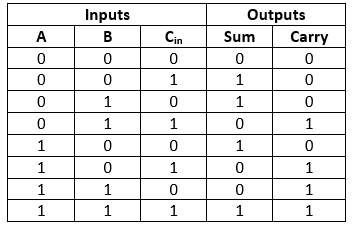

In [17]:
# Define the inputs and labels
full_adder_inputs = np.array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 1, 0],
                   [0, 1, 1],
                   [1, 0, 0],
                   [1, 0, 1],
                   [1, 1, 0],
                   [1, 1, 1]])

# We define outputs
full_adder_labels  = np.array([[0, 0],
                    [1, 0],
                    [1, 0],
                    [0, 1],
                    [1, 0],
                    [0, 1],
                    [0, 1],
                    [1, 1]])

# Convert to integer classes instead
full_adder_labels = np.array([base2_val(l) for l in full_adder_labels])

**Dataset 2:** Truth table for if the sum of binary digits is even for 17 inputs (multivariate XOR)

In [18]:
from itertools import product

def generate_even_table(n):
    inputs = np.array([i for i in product(range(2), repeat=n)])
    outputs = np.array([np.sum(row) % 2 for row in inputs])
    
    return inputs, outputs

inputs_sum_even, outputs_sum_even = generate_even_table(10)

Lets evaluate the algorithms on these datasets.

In [19]:
m_alg8, _ = alg8_model(full_adder_inputs, full_adder_labels)
correct = evaluator(full_adder_inputs, full_adder_labels, m_alg8)
print_evaluation(full_adder_inputs, correct, m_alg8, 'full_adder', 'alg8')

alg8 on full_adder:
Accuracy: 1.0
Dataset length: 8, if statements: 6, ratio: 1.3333333333333333
Dataset dimensions: rows: 8, dimesions: 3



In [20]:
n_model, _ = neighbour_model(full_adder_inputs, full_adder_labels)
correct = evaluator(full_adder_inputs, full_adder_labels, n_model)
print_evaluation(full_adder_inputs, correct, n_model, 'full_adder', 'neighbour')

neighbour on full_adder:
Accuracy: 1.0
Dataset length: 8, if statements: 8, ratio: 1.0
Dataset dimensions: rows: 8, dimesions: 3



In [21]:
m_alg8, _ = alg8_model(inputs_sum_even, outputs_sum_even)
correct = evaluator(inputs_sum_even, outputs_sum_even, m_alg8)
print_evaluation(inputs_sum_even, correct, m_alg8, 'inputs_sum_even', 'alg8')

alg8 on inputs_sum_even:
Accuracy: 1.0
Dataset length: 1024, if statements: 683, ratio: 1.499267935578331
Dataset dimensions: rows: 1024, dimesions: 10



In [22]:
n_model, _ = neighbour_model(inputs_sum_even, outputs_sum_even)
correct = evaluator(inputs_sum_even, outputs_sum_even, n_model)
print_evaluation(inputs_sum_even, correct, n_model, 'inputs_sum_even', 'neighbour')


neighbour on inputs_sum_even:
Accuracy: 1.0
Dataset length: 1024, if statements: 1024, ratio: 1.0
Dataset dimensions: rows: 1024, dimesions: 10



We see that the alg_8 implementation gets a ratio of rows to if-statements of 1.333... on dataset 1 and 1.49 on dataset 2. This is quite good regarding the simplicity of the algorithm, and the low dimensional dataset. Also the first dataset has 4 classes.

The neighbour algorithm uses the same amount of if-statements as the number of rows in the dataset for both dataset. It is therefore not able to generalize anything at these datasets. This was suprisingly bad, but the dimensionality is quite low, and the algorithm is not very sophisticated.

**c.)** We will also evaluate the algorithms on random datasets, with different number of rows and dimensions.

We tested the algorithms on the following random data:
- 25 rows, 25 dimensions
- 25 rows, 50 dimensions
- 25 rows, 100 dimensions
- 50 rows, 100 dimensions

We repeat these tests 100 times for each case.

In [23]:
def generate_unique_vectors(rows, sampling_function):

    seen = set()

    while len(seen) < rows:
        vector = sampling_function()
        seen.add(tuple(vector))

    return np.array(list(seen))

In [24]:
from collections import defaultdict

def random_dataset(rows, dimensions, classes):
    data_input = np.random.randint(0, classes, (rows, dimensions))
    data_output = np.random.randint(0, classes, rows)
    return data_input, data_output

def random_dataset_evaluation(test_scenarios, repeats=10):

    for scenario in test_scenarios:
        print("-----------------------------------")
        correct_counter = defaultdict(lambda: 0)
        if_statement_counter = defaultdict(lambda: 0)

        for _ in range(repeats):
            rows, dimensions, classes = scenario[0]
            data_input, data_output = random_dataset(rows, dimensions, classes)

            for model, model_name in scenario[1]:
                my_model, _ = model(data_input, data_output)

                correct = evaluator(data_input, data_output, my_model)
                correct_counter[model_name] += correct
                if_statement_counter[model_name] += len(my_model)

        for model_name in correct_counter:
            print(f'{model_name} on random dataset {rows}x{dimensions}x{classes}:')
            print(f'Average accuracy: {correct_counter[model_name]/(repeats*rows)}')
            print(f'Average if statements: {if_statement_counter[model_name]/repeats}')
            print(f'Average ratio: {repeats*rows/if_statement_counter[model_name]}')
            print()
            

# (rows, dimensions, classes), model_creator, 
test_scenarios = [((25, 25, 2), [(alg8_model, 'alg8_model'), (neighbour_model, 'neighbour_model')]),
                  ((25, 50, 2), [(alg8_model, 'alg8_model'), (neighbour_model, 'neighbour_model')]),
                  ((25, 100, 2), [(alg8_model, 'alg8_model'), (neighbour_model, 'neighbour_model')]),
                  ((50, 100, 2), [(alg8_model, 'alg8_model'), (neighbour_model, 'neighbour_model')])]

random_dataset_evaluation(test_scenarios, repeats=100)


-----------------------------------
alg8_model on random dataset 25x25x2:
Average accuracy: 1.0
Average if statements: 13.5
Average ratio: 1.8518518518518519

neighbour_model on random dataset 25x25x2:
Average accuracy: 1.0
Average if statements: 21.82
Average ratio: 1.1457378551787352

-----------------------------------
alg8_model on random dataset 25x50x2:
Average accuracy: 1.0
Average if statements: 13.34
Average ratio: 1.8740629685157422

neighbour_model on random dataset 25x50x2:
Average accuracy: 1.0
Average if statements: 22.38
Average ratio: 1.1170688114387846

-----------------------------------
alg8_model on random dataset 25x100x2:
Average accuracy: 1.0
Average if statements: 13.58
Average ratio: 1.840942562592047

neighbour_model on random dataset 25x100x2:
Average accuracy: 1.0
Average if statements: 21.88
Average ratio: 1.1425959780621573

-----------------------------------
alg8_model on random dataset 50x100x2:
Average accuracy: 1.0
Average if statements: 26.36
Average

**NB!:** *The exact values discussed here changes a bit between every run*

We see that alg_8 is able to generalize quite well, and the ratio of rows to if-statements goes from 1.828 to 1.927 as the dimensionality increases from 25 to 100 in the cases with 25 rows. The ratio goes from 1.927 to 1.953 when increasing the number of rows from 25 to 50, while keeping the dimensionality at 100. This shows that this algorithm seems to converge to the 2 bits of information per paramter ration, which is the best we can do in general.

For the neighbour algorithm, we also see that the ratio of rows to if-statements increases as the dimension increases, and also when we increase the number of rows in the last case. The best ratio is still 1.16, which is quite bad.

## 6.3

**a.)**

We will have a look at huffman coding for this compression. On random data with high information entropy we can't expect a high compression rate. 

*We assume our characters are ascii characters of 1 byte each.*

We will try some different strings:
-   one with reasonable words from some alice in wonderland text (I think), from online. 
-   one with just random alphabetic charecters, that one would use to form words.
-   one with uniformly chosen random charachters from all 256 ascii characters.

In [25]:
from dahuffman import HuffmanCodec
import requests
import random
import string


def huffman_compress_test(text):
    # Create a HuffmanCodec object
    codec = HuffmanCodec.from_data(text)

    # Encode the text
    compressed_data = codec.encode(text)

    # Decode the encoded data
    decoded_data = codec.decode(compressed_data)

    print("Original text length:", len(text), "bytes")
    print("Compressed data length:", len(compressed_data), "bytes")
    print("Decoded text:", len(decoded_data))
    equality = text == decoded_data
    print("Reconstruction successful:", equality)
    compression_rate = (len(text)-len(compressed_data))/len(text)
    print("Compression rate", compression_rate)

# URL of the text file from Project Gutenberg
url = "https://www.gutenberg.org/files/11/11-0.txt"
# Download the text file
response = requests.get(url)
normal_text = response.text
print("Normal text compression evaluation:")
huffman_compress_test(normal_text)
print()

# Try random text
# Define the characters to choose from
text_characters = string.ascii_letters + string.digits + string.punctuation + ' '
random_text = random_text = ''.join(random.choice(text_characters) for _ in range(int(1e5)))
print("Random textual-like characters compression evaluation:")
huffman_compress_test(random_text)
print()

# Try all random ascii characters
random_characters = ''.join([chr(i) for i in range(256)])
random_ascii_text = ''.join(random.choice(random_characters) for _ in range(int(1e5)))
print("Random ascii characters compression evaluation:")
huffman_compress_test(random_ascii_text)
print()

Normal text compression evaluation:
Original text length: 154638 bytes
Compressed data length: 92073 bytes
Decoded text: 154638
Reconstruction successful: True
Compression rate 0.4045900748845691

Random textual-like characters compression evaluation:
Original text length: 100000 bytes
Compressed data length: 83172 bytes
Decoded text: 100000
Reconstruction successful: True
Compression rate 0.16828

Random ascii characters compression evaluation:
Original text length: 100000 bytes
Compressed data length: 100043 bytes
Decoded text: 100000
Reconstruction successful: True
Compression rate -0.00043



As expected, a text written by a human  has some probabilities that lets us compress it with 40%.

Random characters that we usually see in text can also be compresses by 16%, as these characters are only a subset of the 256 characters representable by 8 bytes, so there are some characters not used in normal text, that have very low probabilities of appearing (soem have 0).

The task seems to ask about a string with all characters randomly chosen from all possible characters. This string can't be compressed at all, as the entropy is 8 bits per character, since they are all just as likely to appear. We see this from the last example above.

**b.)**
For random characters we can't expect any compression, as the entropy is 8 bits per character. As we see above, what distribution the characters is chosen from affects the compression rate.

## 8.1

We want to find the memory equivalent capacity (MEC) of the following models:

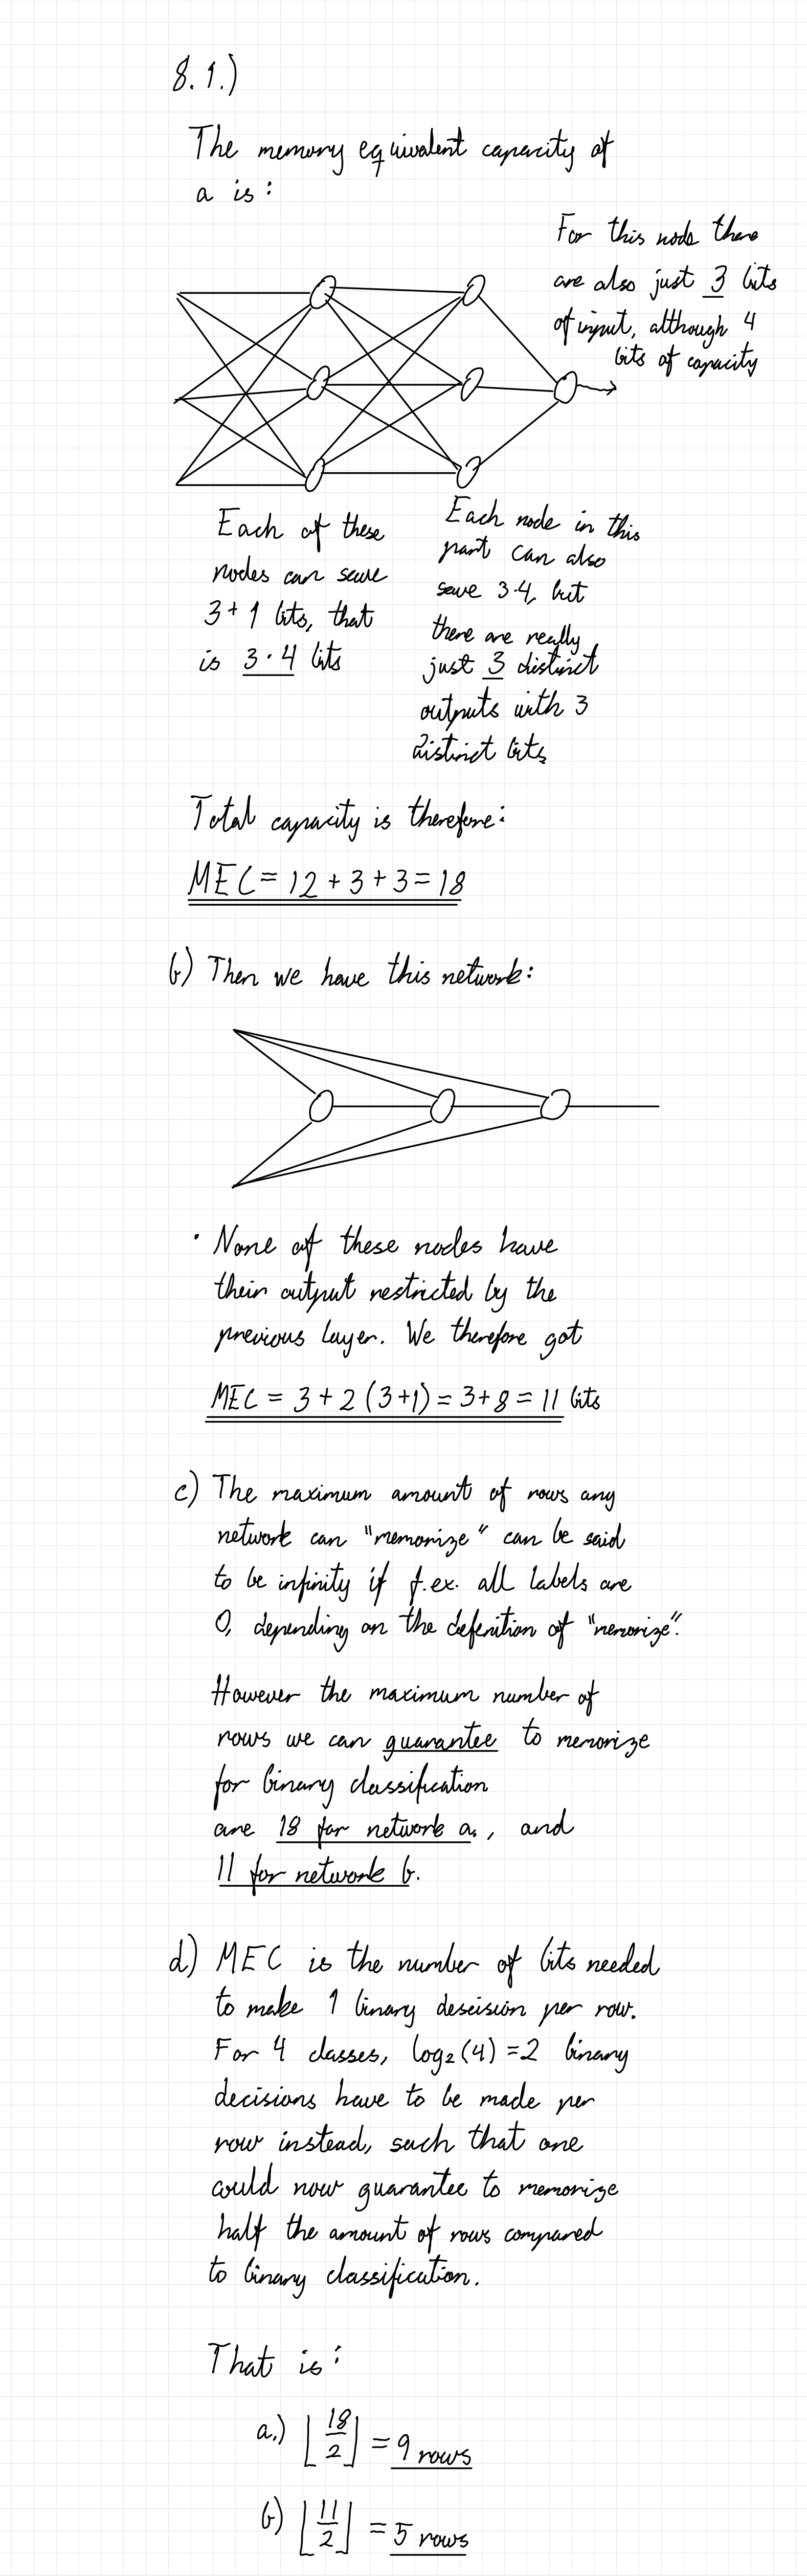

**a.)** The

## 8.2
The definition of MEC says: "A model’s intellectual capacity is memory equivalent to n bits when the model is able to represent all $2^n$ binary labeling functions of n points.". In this problem there are 12 points, and we therefore need a MEC of 12 bits to guarantee memorization. Here are two examples of this:

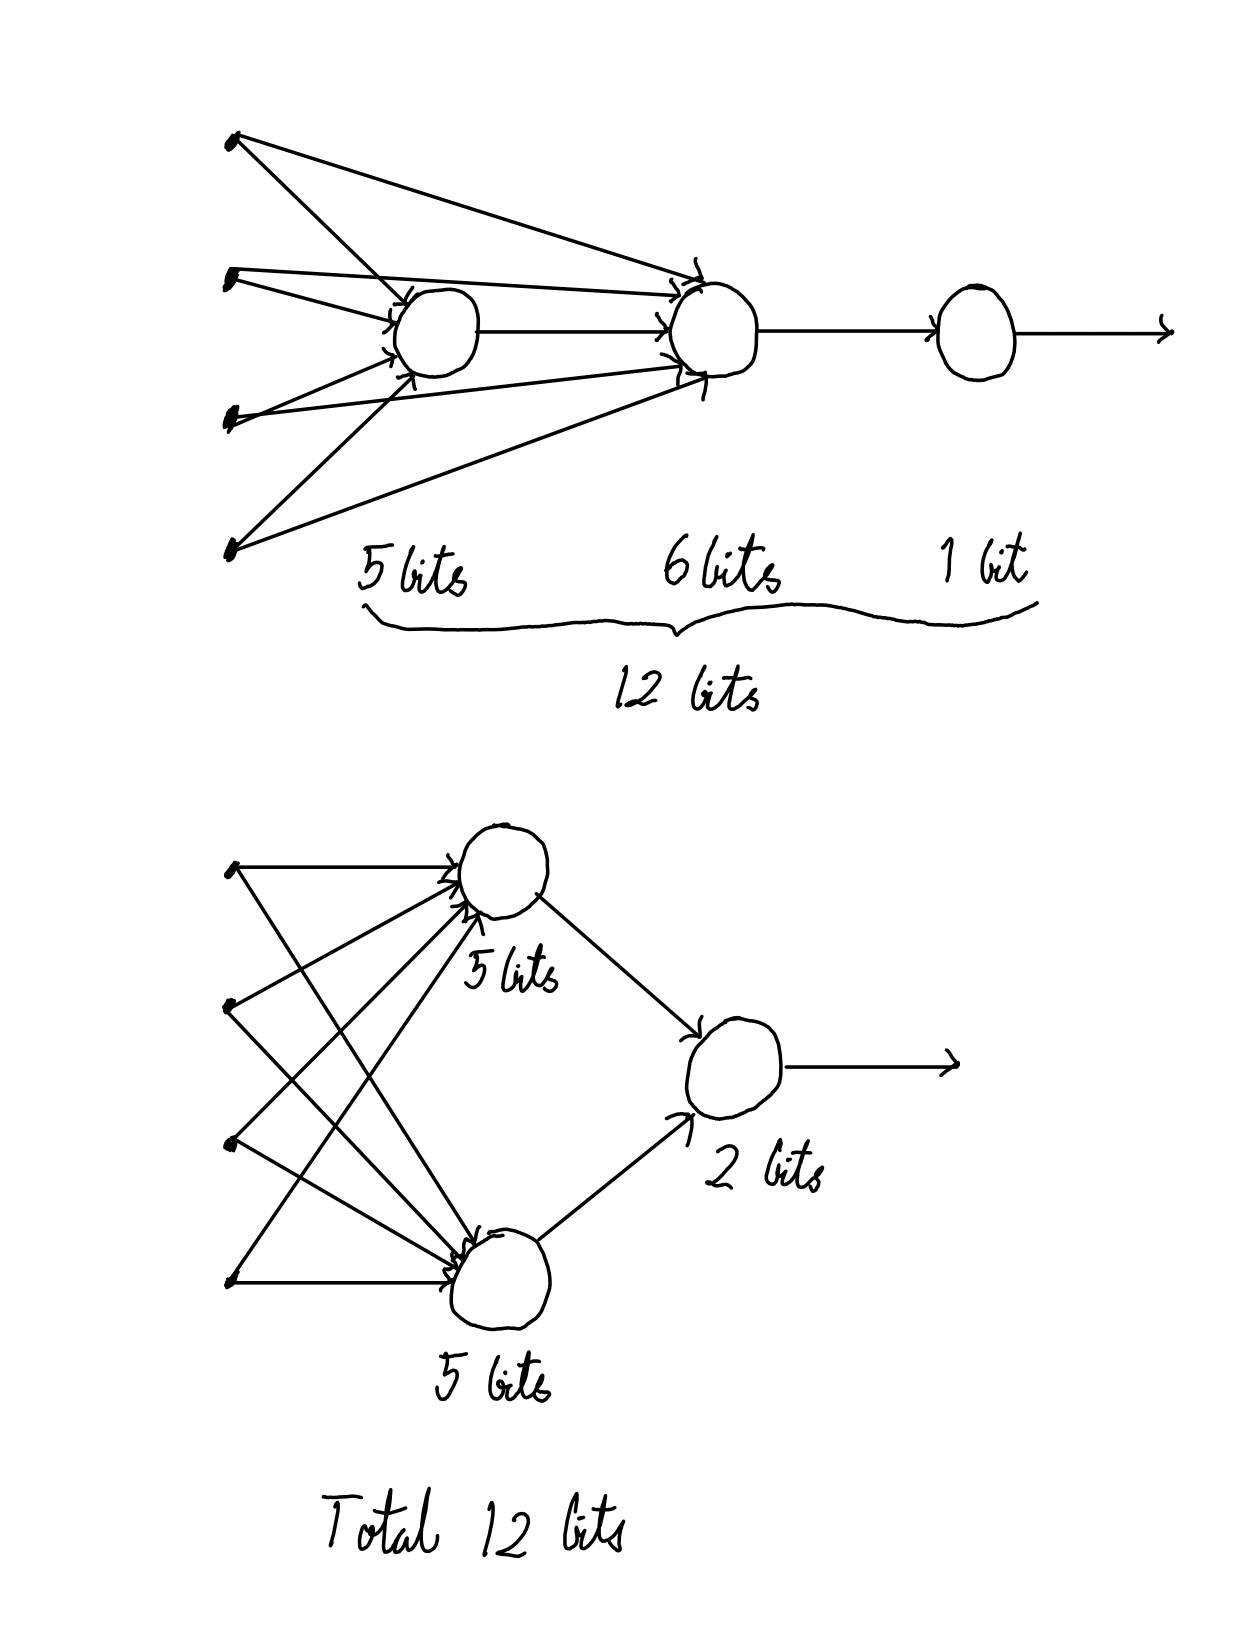


## 8.4
**a.)** 

First I want to state that the interpration of this task could be a bit unclear. For example there is a difference in the amount of information that our sensors "experience" given no prior estimation of the likelihood of different events vs. the amount of information we actually pay attention to as a human that can recognize normal or unusual events. We can't turn of our ears, however we subconsciously ignore a lot of the sounds we hear. The same goes for our eyes. We can't turn of our eyes, but we can ignore a lot of the things we see. After all this is might just a reflection of the amount of the amount of uncertainty we can reduce by focusing on the right sensory information. If there is happening something very visually unusual in my room, I will probably pay more attention. Like if there is a fire. This usually never happens, so paying attention reduces my uncertainty.

The first part of this task seems to be about the amount data that our sensors would take in during a lifetime, and not actually what we pay attention to. 
The second part about memorization seems to be more about the amount of information we actually pay attention to.

**What sensory information can a human take in?**
- Vision
- Audio
- Physical touch
- Smell
- Taste
- (Temperature)
- (Balance)

**First let's get some more info about each sensor**:

- Vision:
    - This article suggests that the retina feeds the brain with 10 million bits per second: https://www.edwardtufte.com/bboard/q-and-a-fetch-msg?msg_id=0002NC#:~:text=The%20research%20suggests%20that%20the,close%20to%20an%20Ethernet%20connection!. Another article claimed 576MP at 30 fps, altough this seems unreasonable, so I will use the first article as my basis.
        - This does not take into account the actual entropy of the data. Let's say I watch a youtube video. The youtube video is compressed, and I will not take in more info than the optimal compression of the video. I will therefore not experience more than 10 million bits per second, unless the compressed video surpasses this amount of information rate.
- Audiotory:
    - A normal healthy human can hear from 20 Hz to 20 kHz.
    - A professional audio setup would use something lik 24 bit at 44.1 kHz (because we can hear up to 20 kHz, and need higher sampling rate). This would be 24*44.1*1000 bits = 1.0584 million bits per second.
    - Let's say this is the amount of data we take in every second of listening, since that is what is needed for profeesionals to not notice any loss in quality.
- Other:
    - It is very difficult to measure the amount of information taken in by other sensors, as it would be just guessing. Anyways, some articles suggests that up to 90% of the information we take in comes from the eyes. Let's say the eyes gives 10 million bits per second, the ears 1 million bits per second, and the rest of the sensors 1 million bits per second. This would make the total amount of information taken in about **12 million bits per second**.
    - Let's also assume that we sleep for 8 hours every night, and that our sensors are close to being turned off during this time. 

**At the age of 23, this would give a total of:**
$$
12 \cdot 10^6 bits/s \cdot 60 s/min \cdot 60 min/h \cdot (24-8) h/day \cdot 365 days/year \cdot 23 years = 5.8026 \cdot 10^{15} bits
$$

**How much have me memorized?**


- This is a difficult question to answer. First we have to think about how we process data. Even though I see a very detailed view of the world, I don't save these details to memory. If I see a new car, the only really new data I take in is how different concepts that I already now, connects together. This would be concepts like shape and color, that I have already memorized.
- I will choose to focus on the vision part of information, as this is reported to be up to 90% of the information we take in. It would therefore be a good estimate for the total memorization.
- The brain seems to memorize shapes and colors, and then connects these to concepts. These concepts are also memorized.

- Lets look at an image I found online: https://vecta.io/blog/comparing-svg-and-png-file-sizes/penrose-triangle.d6e2a09434.svg:

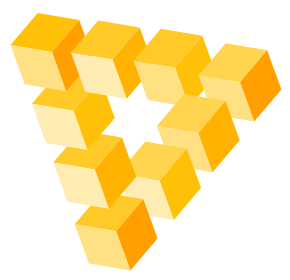

By using a zipped vectorized format (svgz), they are able to save this image in 621 Bytes, while when using reasonable PNG resolutions they use several kilobytes for 1 image. Let's assume that one scene of my life consists of 1000 shapes of this complexity worth memorizing. This would be **621 kilobytes** of information for 1 scene. Usually half of my day is spent between 4-6 different scenes at home, and the other half is spent at the university changing between maybe 10 scenes. With no prior knowledge of the world, I would have to memorize about $621 kilobyte/scene \cdot 15 scenes = 9315 kilobytes = 7.45 \cdot 10^7 bits$ of information. However each day I would only have to memorize the new information I take in. Let's say I have to connect these shapes to new memories at a rate of 10% of the above every day, altough this rate would get smaller the more I experience (we ignore this for simplicity). Let's also assume that we start very fresh, and have to start reconnecting these shapes every 5 years, for reasons like moving to new places and similar stuff. This happens 10 time. Altough this does not require to relearn everything, let's just assume it does. This would give a total of:

$$
10 * (7.45 \cdot 10^7 bits + (7.45 \cdot 10^7 bits/day*0.1 \cdot 365 days/year * 5 years)) = 136707500000 bits = 1.367 \cdot 10^{11} bits
$$

I will note that it is very difficult to estimate the amount of information we memorize. This is a very guessy estimate based on the vision part of our mind. But hopefully it is within maybe 4 magnitudes of order of the real amount of information we memorize.

**Works of shakespare:**

- According to this article, shakespare wrote 38 plays, 2 narrative poems, and 154 sonnets. 884,647 words: https://www.shakespeare-online.com/biography/wordsinvented.html
- According to this website, shakespare wrote about 835000 words: https://www.opensourceshakespeare.org/views/plays/plays_numwords.php. 
- According to this wikipedia website, the english language has about 0.6 to 1.3 bits of information per letter: https://en.wikipedia.org/wiki/Entropy_(information_theory)#:~:text=English%20text%20has%20between%200.6,per%20character%20of%20the%20message.
- Combining this information we get a total of:
$$
835000 words \cdot 1 bit/word = 835000 bits = 8.35 \cdot 10^5 bits
$$

**Total information capacity of the brain:**

Since image and accoustic data is assumed to be fairly high dimensional, we can assume two bits of information per connection in the brain. Each connection involves two neurons, such that for $10^{11}$ neurons with $1000$ connections each, we get a total of $10^{11} \cdot \frac{1000}{2}$ total connections, that would be the equivilant of parameters for a neural network. This gives the following information capacity for the brain:

$$
Information-capcity = 10^{11} \cdot \frac{1000}{2} \cdot 2 = 10^{14} bits
$$

This is 9 magnitudes of order more than needed to memorize all of shakespare's plays. It is also 3 orders of magnitude higher than the estimated amount of information we memorize in a lifetime. The memorization estimation was very guessy, but it this might suggest that the brain could memorize even more than we already do.


**b.)** From what we see in about algorithm 8, we find a certain amount of tresheld needed to classify a table. If we are handling more classes the treshold calculations will still work the same way, although the MEC symbolizes the capacity given that we are decisidng between two classes (binary). If we are instead desiding between 4 classes, it would be the equivilant of doing 2 binary classifications, requiring twice the amount of MEC. We can formulize this as follows:

$$
MEC_c = MEC_2 \cdot log_2(c)
$$

This would be the extra line of code we would at to the end of algorithm 8.


**c.)** For regression we could say that each row has it's own class. That would lead to to the need for N classes. One class for every row. This would also mean that we need $tresholds = N$ and $classes = N$. We would not need the algorithm for this. The whole calculation can be done in a mathematical expression:

$$
MEC_{regression} = log_2(tresholds + 1) \cdot log_2(N) = log_2(N + 1) \cdot log_2(N)
$$

## 9.1

For solving this task we will do the following:
- We will look at the mutual information in the training data to find the MEC needed after compression.
- We will design a CNN that compresses the data reasonably given the MEC found above.
- We will make the fully connected network after the CNN have maximally the MEC found above. It should probably be lower.

**Mutual information in the training data:**

From the book we have that the maximal mutual information is given by the following formula:

$$
I(X; Y)_{\text{max}} = \min(H(X), H(Y))
$$

Therefore we would only need to calculate the entropy of the labels to find an upper bound for the MEC.

The MNIST database contains 60,000 training images and 10,000 testing images. The images are 28x28 pixels grayscale, and each pixel is represented by a value between 0 and 255. This could correspond to a table of **60,000 rows** and **784 columns**, with **10 classes**. This suggests that we would need the following MEC to remember the whole dataset given that the labels are equally distributed:
$$
MEC = \lceil 60000 \cdot log_2(10) \rceil = 199316 bits
$$

Let's calculate this by using the actual MNIST dataset as well:


In [26]:
import torch
from torchvision import datasets, transforms

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.PILToTensor())
mnist_labels = mnist_dataset.targets

label_counts = torch.unique(mnist_labels, return_counts=True)[1]
probabilities = label_counts / mnist_labels.shape[0]
entropy = -torch.sum(probabilities * torch.log2(probabilities)).item()

eq_memory_cap = mnist_dataset.data.shape[0]*mnist_dataset.data.shape[1]*mnist_dataset.data.shape[2]*8
print("Entropy per row:", entropy, "Total entropy:", entropy*mnist_labels.shape[0])
print("Memory capacity of a corresponding table:", eq_memory_cap, "bits")
print("Suggested maximum compression rate:", eq_memory_cap/(entropy*mnist_labels.shape[0]))

Entropy per row: 3.319870948791504 Total entropy: 199192.25692749023
Memory capacity of a corresponding table: 376320000 bits
Suggested maximum compression rate: 1889.2300624767138


**Maximum compression**

We see that both our simple theory and the actual data gives us a MEC of about $199000 bits$ or $log_2(10) = 3.3219 bits$ per row.

Our input data is $28*28*8bits = 6272bits$ per row. Our data should maximally be compressed down to $3.3219bits$ (corresponding to 10 classes). This is a compression rate of $6272/3.3219 = 1889$. Since the labels are equally distributed we could simply calculate this by looking at 1 row and the 10 classes. However a corresping calculation using the whole table is done in the code above.


**Thoughts about Fully connected network:**

If we were to design the last fully connected part of the model as 1 hidden layer having the sam amounts of inputs and neurons, and 1 output layer (10 nodes), we would approximatly need $\sqrt(199000) = 446$ neurons. This would give a MEC of:
$$
MEC = 446 * (446 + 1) = 199362 bits
$$

Let's say we need only $199000/4$ bits of memory, since many of the data points are very similar for the different digits in MNIST.
Then we could have 1 hidden layer with $\sqrt(199000/6) = 223$, giving:
$$
MEC = 223 * (223 + 1) = 49952 bits
$$

We could also add a second hidden layer of a chosen size. It will not add much capacity as the output of the 223 neurons are 223 bits. We could for example add a second layer of 50 neurons, giving 223 extra bits of capacity. Then we add the last layer of 1o neurons, adding another 10 bits. The main benefit of the 3 layers is the theoretical foundation in th book that shows a 3 layer network can represent any functions.


**Designing the CNN:**

- We will use 3x3 kernels as this seems to be the best choise according to articles. We will also use RELU activation functions.
- Let's first add 2 layers with output_channels = 2*input_channels, stride 1, and then max pooling with stride 2. This does a total compression with ratio $4$
- Let's then do 1 layers with output_channel = 3*input_channels, stride 1 and max pooling with stride 2. This does a total compression of $\frac{4}{3}$
- Now our total compression is $\frac{16}{3}=5.33...$. After some padding and other stuff we end up with 192 outputs.
    - This differs a little bit from what we found above, but this would give approximatly a MEC of $192 * (192 + 1) = 37056 bits$, which could work.

Since we are just trying to observe how different models behave, I evaluate accuracies on the whole train and test set every epoch.

In [27]:
class UnOptimalCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=4, kernel_size=4, stride=3, padding=1),
            torch.nn.ReLU()
        )
        self.linear = torch.nn.Linear(16, 10)

    def forward(self, x):
        x = self.model(x)
        x = self.linear(x.flatten(start_dim=1))
        return x

    def get_param_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class OptimalCNN(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_sequence = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=2),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool2d(kernel_size=3, stride=2),
                    torch.nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=2),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool2d(kernel_size=3, stride=2),
                    torch.nn.Conv2d(in_channels=4, out_channels=12, kernel_size=3, stride=1, padding=2),
                    torch.nn.ReLU(),
                    torch.nn.MaxPool2d(kernel_size=3, stride=2))

        self.full_connected_sequence = torch.nn.Sequential(torch.nn.Linear(12*4*4, 50),
                                                           torch.nn.ReLU(),
                                                           torch.nn.Linear(50, 10))               


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = self.conv_sequence(x)
        x = self.full_connected_sequence(x.flatten(start_dim=1))

        return x
    
    def get_param_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def eval_on_set(data_loader, model, normalizer):

    acc = []
    with torch.no_grad():

        for inputs, labels in data_loader:

            outputs = model(normalizer(inputs.float()))

            _, preds = torch.max(outputs, dim=-1)
            acc.append(torch.sum(preds == labels).item() / len(preds))

    return sum(acc) / len(acc)

def train_model(model, data_loader, test_data_loader, criteria, optimizer, normalizer, num_epochs=15):

    train_losses = []
    train_accs = []
    test_accs = []

    for _ in range(num_epochs):

        epoch_loss = []
        for inputs, labels in data_loader:

            # Forward pass
            outputs = model(normalizer(inputs.float()))

            # Calculate the loss, the input is our target
            loss = criteria(outputs, labels)
            epoch_loss.append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        train_accs.append(eval_on_set(data_loader, model, normalizer))
        test_accs.append(eval_on_set(test_data_loader, model, normalizer))

        model.train()

        train_losses.append(sum(epoch_loss) / len(epoch_loss))

        print("Loss:", train_losses[-1], "Train Accuracy:", train_accs[-1], "Test Accuracy:", test_accs[-1])

    return train_losses, train_accs, test_accs

mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.PILToTensor())
mnist_test_data_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=50, shuffle=True)

mnist_data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=50, shuffle=True)

d_mean = mnist_data_loader.dataset.data.float().mean(axis=(0,1,2))
d_std = mnist_data_loader.dataset.data.float().std(axis=(0,1,2))
normalizer = transforms.Normalize(mean=d_mean, std=d_std)


criteria = torch.nn.CrossEntropyLoss()



We will first test the CNN that I randomly designed, without reading the book. I have seen that adding a lot of channels is done sometimes, so I tried doing the same. Then adding a fully connected network at the end.

In [28]:
my_model = UnOptimalCNN()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

print("Params:", my_model.get_param_count())
unopt_losses, unopt_train_accs, unopt_test_accs = train_model(my_model, mnist_data_loader, mnist_test_data_loader, criteria, optimizer, normalizer, num_epochs=200)

Params: 43102
Loss: 0.3355434899458972 Train Accuracy: 0.9558666666666785 Test Accuracy: 0.957699999999999
Loss: 0.1166586212158048 Train Accuracy: 0.9727333333333452 Test Accuracy: 0.9726999999999987
Loss: 0.08670681506424444 Train Accuracy: 0.9793833333333437 Test Accuracy: 0.9801999999999988
Loss: 0.07102247481399293 Train Accuracy: 0.9833500000000087 Test Accuracy: 0.9803999999999994
Loss: 0.0602903892082395 Train Accuracy: 0.9796000000000092 Test Accuracy: 0.9779999999999989
Loss: 0.05313386756955879 Train Accuracy: 0.9810333333333429 Test Accuracy: 0.9789999999999986
Loss: 0.04641463556103796 Train Accuracy: 0.9884833333333395 Test Accuracy: 0.982599999999999
Loss: 0.041603324858782195 Train Accuracy: 0.9890166666666727 Test Accuracy: 0.9844999999999993
Loss: 0.03779659893390393 Train Accuracy: 0.9897333333333395 Test Accuracy: 0.9829999999999994
Loss: 0.03372260341134582 Train Accuracy: 0.9903666666666722 Test Accuracy: 0.9849999999999991
Loss: 0.03074871718169258 Train Accuracy

In [ ]:
my_model = OptimalCNN()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

print("Params:", my_model.get_param_count())
opt_losses, opt_train_accs, opt_test_accs = train_model(my_model, mnist_data_loader, mnist_test_data_loader, criteria, optimizer, normalizer, num_epochs=200)

Params: 10700


Loss: 0.4494490174305004 Train Accuracy: 0.9406833333333439 Test Accuracy: 0.9461999999999989
Loss: 0.16757768360277017 Train Accuracy: 0.9544500000000132 Test Accuracy: 0.9578999999999992
Loss: 0.12920196273752177 Train Accuracy: 0.9654333333333452 Test Accuracy: 0.9668999999999991
Loss: 0.11237522393620263 Train Accuracy: 0.9735333333333449 Test Accuracy: 0.9751999999999987
Loss: 0.09771996556664816 Train Accuracy: 0.9723500000000109 Test Accuracy: 0.9748999999999992
Loss: 0.08891901440084136 Train Accuracy: 0.9736833333333446 Test Accuracy: 0.9769999999999994
Loss: 0.08445598732369641 Train Accuracy: 0.9774000000000109 Test Accuracy: 0.9777999999999994
Loss: 0.0766716962774323 Train Accuracy: 0.977866666666676 Test Accuracy: 0.9794999999999989
Loss: 0.07187321509525646 Train Accuracy: 0.9801833333333431 Test Accuracy: 0.9793999999999993
Loss: 0.0696111466146734 Train Accuracy: 0.9779166666666773 Test Accuracy: 0.977999999999999
Loss: 0.0660101891962889 Train Accuracy: 0.981416666666

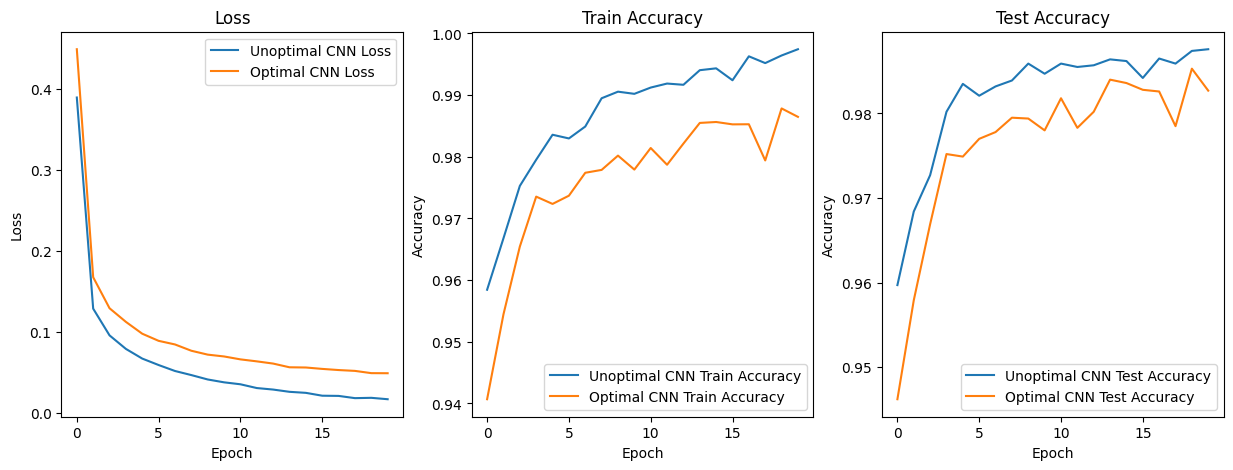

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(unopt_losses, label='Unoptimal CNN Loss')
ax[0].plot(opt_losses, label='Optimal CNN Loss')
ax[0].legend()
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')

ax[1].plot(unopt_train_accs, label='Unoptimal CNN Train Accuracy')
ax[1].plot(opt_train_accs, label='Optimal CNN Train Accuracy')
ax[1].legend()
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Train Accuracy')

ax[2].plot(unopt_test_accs, label='Unoptimal CNN Test Accuracy')
ax[2].plot(opt_test_accs, label='Optimal CNN Test Accuracy')
ax[2].legend()
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_title('Test Accuracy')

plt.show()